In [13]:
import pandas as pd
import sqlite3

# Підключення до SQLite
conn = sqlite3.connect("stolen_vehicles.db")

def load_data(file_path, table_name, conn):
    df = pd.read_csv(file_path)
    df.to_sql(table_name, conn, if_exists='replace', index=False)

load_data("D:\Hakathon\Data\zip2\locations.csv", "locations", conn)
load_data("D:\Hakathon\Data\zip2\make_details.csv", "make_details", conn)
load_data("D:\Hakathon\Data\zip2\stolen_vehicles.csv", "stolen_vehicles", conn)

In [ ]:
#3.В який день тижня автомобілі крадуть найчастіше та найрідше?

In [14]:
stolen_vehicles = pd.read_sql("SELECT * FROM stolen_vehicles", conn)

In [16]:
stolen_vehicles['date_stolen'] = pd.to_datetime(stolen_vehicles['date_stolen'])
stolen_vehicles['day_of_week'] = stolen_vehicles['date_stolen'].dt.day_name()
day_counts = stolen_vehicles['day_of_week'].value_counts()
most_frequent_day = day_counts.idxmax()
least_frequent_day = day_counts.idxmin()
print(f"Most frequent: {most_frequent_day}")
print(f"Least frequent: {least_frequent_day}")

Most frequent: Monday
Least frequent: Saturday


In [ ]:
#4.Які види транспортних засобів крадуть частіше, а які рідше? Чи
#відрізняються ці показники за регіонами? (Бажано побудувати графік)

In [20]:
locations = pd.read_sql("SELECT * FROM locations", conn)

In [45]:
vehicle_type_counts = stolen_vehicles.groupby(['vehicle_type', 'location_id']).size().reset_index(name='count')
vehicle_type_counts = vehicle_type_counts.merge(locations, on='location_id', how='left')
vehicle_type_counts_sorted = vehicle_type_counts.sort_values(by='count', ascending=False)

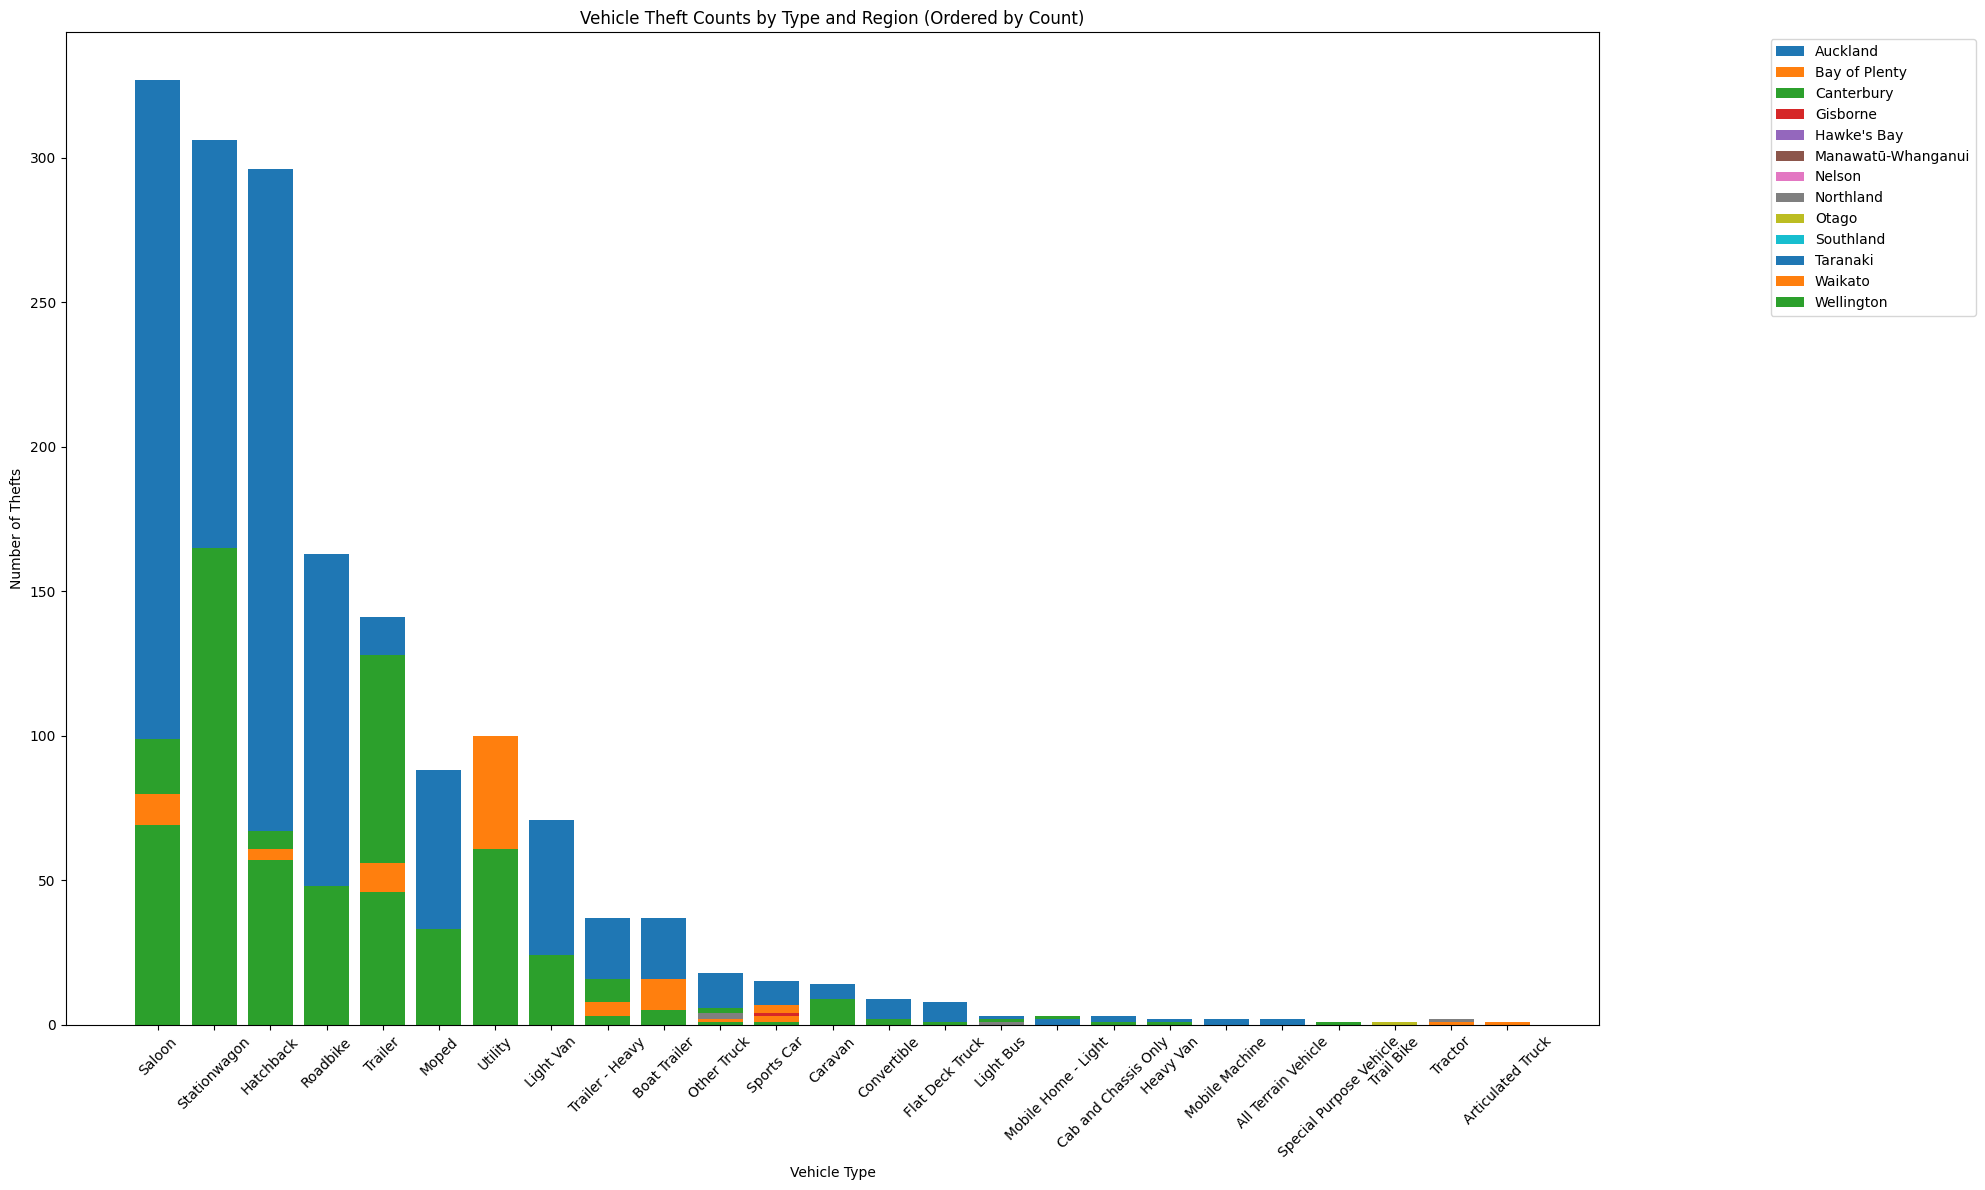

In [54]:
plt.figure(figsize=(20, 12))
for region, data in vehicle_type_counts_sorted.groupby('region'):
    plt.bar(data['vehicle_type'], data['count'], label=region)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.title('Vehicle Theft Counts by Type and Region (Ordered by Count)')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Thefts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# Summarize the data by vehicle type and region
vehicle_region_counts = vehicle_type_counts_sorted.groupby(['region', 'vehicle_type'])['count'].sum().reset_index()

# Identify the most and least stolen vehicle types by region
most_stolen_by_region = vehicle_region_counts.loc[vehicle_region_counts.groupby('region')['count'].idxmax()]
least_stolen_by_region = vehicle_region_counts.loc[vehicle_region_counts.groupby('region')['count'].idxmin()]

# Combine most and least stolen data into a single table
stolen_summary = most_stolen_by_region.rename(columns={'vehicle_type': 'Most Stolen Vehicle', 'count': 'Most Stolen Count'})
stolen_summary['Least Stolen Vehicle'] = least_stolen_by_region['vehicle_type'].values
stolen_summary['Least Stolen Count'] = least_stolen_by_region['count'].values

# Display the table
print(stolen_summary)


                 region Most Stolen Vehicle  Most Stolen Count  \
14             Auckland              Saloon                327   
34        Bay of Plenty             Utility                100   
52           Canterbury        Stationwagon                165   
65             Gisborne              Saloon                 41   
82          Hawke's Bay             Trailer                 23   
95   Manawatū-Whanganui        Stationwagon                 29   
111              Nelson             Trailer                 19   
128           Northland        Stationwagon                 69   
144               Otago        Stationwagon                 31   
153           Southland        Stationwagon                  9   
165            Taranaki        Stationwagon                 23   
179             Waikato              Saloon                 80   
198          Wellington        Stationwagon                 92   

     Least Stolen Vehicle  Least Stolen Count  
14              Heavy Van  

In [79]:
styled_stolen_summary = stolen_summary.style.set_caption("Vehicle Theft Summary by Region") \
    .hide(axis="index") \
    .set_table_styles([
        {"selector": "caption", "props": [("color", "black"), ("font-size", "16px"), ("text-align", "center")]},
        {"selector": "th", "props": [("background-color", "lightblue"), ("font-size", "12px")]},
        {"selector": "td", "props": [("text-align", "center")]} 
    ])

styled_stolen_summary

region,Most Stolen Vehicle,Most Stolen Count,Least Stolen Vehicle,Least Stolen Count
Auckland,Saloon,327,Heavy Van,2
Bay of Plenty,Utility,100,Convertible,1
Canterbury,Stationwagon,165,Cab and Chassis Only,1
Gisborne,Saloon,41,Flat Deck Truck,1
Hawke's Bay,Trailer,23,Boat Trailer,1
Manawatū-Whanganui,Stationwagon,29,Caravan,1
Nelson,Trailer,19,Heavy Van,1
Northland,Stationwagon,69,All Terrain Vehicle,1
Otago,Stationwagon,31,Cab and Chassis Only,1
Southland,Stationwagon,9,Caravan,1


In [ ]:
#5.Чи є залежність між характеристиками регіону і кількістю крадіжок?
#Дайте розгорнуту відповідь.

In [64]:
locations['population'] = locations['population'].replace(',', '', regex=True).astype(float)
locations['density'] = locations['density'].replace(',', '', regex=True).astype(float)
region_thefts = stolen_vehicles.groupby('location_id').size().reset_index(name='theft_count')
region_analysis = region_thefts.merge(locations, on='location_id', how='left')
correlations = region_analysis[['population', 'density', 'theft_count']].corr()
print("Correlations between region characteristics and theft count:")
print(correlations)

Correlations between region characteristics and theft count:
             population   density  theft_count
population     1.000000  0.827112     0.980118
density        0.827112  1.000000     0.841477
theft_count    0.980118  0.841477     1.000000


In [80]:
styled_correlations = correlations.style.set_caption("Correlations Between Region Characteristics and Theft Count") \
    .background_gradient(cmap="PRGn", axis=None) \
    .format(precision=2) \
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "16px"), ("text-align", "center"), ("color", "black")]},
        {"selector": "th", "props": [("background-color", "lightgrey"), ("font-size", "12px"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]} 
    ])
styled_correlations

,population,density,theft_count
population,1.00,0.83,0.98
density,0.83,1.00,0.84
theft_count,0.98,0.84,1.00
